In [2]:
import torch
from torch import nn
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler

from PIL import Image
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

1.   Creating a custom Dataset class by subclassing the Pytorch Dataset class and splitting the data into training and testing set based on the Partition value present in the annotation.csv file.
2.   Defining transformations for training and testing images (resizing, converting to tensor format, normalisation and augmentations like random horizontal flips).


In [8]:
csv_path = '/content/drive/MyDrive/JJ/annotations.csv'
image_path = '/content/drive/MyDrive/JJ/images'


class CustomDataset(Dataset):
    def __init__(self, csv_path, image_folder, transform=None, partition='train'):
        self.df = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.transform = transform
        self.label_mapping = {"SSA": 1, "HP": 0}
        self.df_partition = self.df[self.df['Partition'] == partition]

    def __len__(self):
        return len(self.df_partition)

    def __getitem__(self, idx):
        img_name = self.df_partition.iloc[idx, 0]
        img_path = f"{self.image_folder}/{img_name}"

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_str = self.df_partition.iloc[idx, 1]
        label = self.label_mapping.get(label_str, -1)
        label = torch.tensor(label)

        return image, label

    def class_distribution(self):
        return self.df_partition['Majority Vote Label'].value_counts()

    def print_dataset(self, num_samples=5):
        print(self.df_partition.head(num_samples))


# Define transformations for images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


#Creating Training and Test Dataset
train_dataset = CustomDataset(csv_path, image_path, transform=train_transform, partition='train')
test_dataset = CustomDataset(csv_path, image_path, transform=test_transform, partition='test')

# Visualising a Batch of Images before and after applying transformations

Data before Transformations


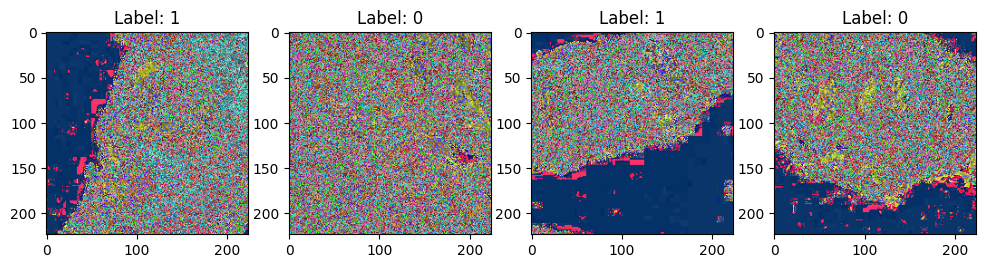

Data after Transformations


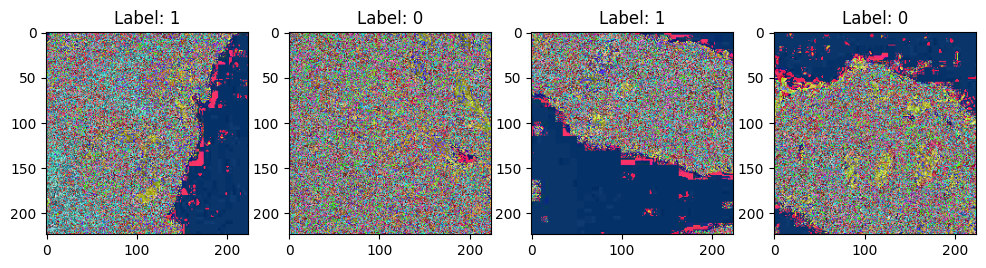

In [12]:
batch = 4
data_loader_trans = DataLoader(train_dataset, batch_size=batch, shuffle=False)
train_notrans = CustomDataset(csv_path, image_path, partition='train')
data_loader = DataLoader(train_notrans, batch_size=batch, shuffle=False)

def show_images_batch(images, labels):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 4))

    for i in range(len(images)):
        img = transforms.ToPILImage()(images[i])
        label = labels[i].item()

        axs[i].imshow(img)
        axs[i].set_title(f'Label: {label}')

    plt.show()

# Iterate through the DataLoader to visualize a batch of data
for batch in data_loader_trans:
    print('Data before Transformations')
    images, labels = batch
    show_images_batch(images, labels)
    break

for batch in data_loader_trans:
    print('Data after Transformations')
    images, labels = batch
    show_images_batch(images, labels)
    break


In [19]:


# Calculate class frequencies for train dataset
class_freq = torch.as_tensor(train_dataset.df_partition['Majority Vote Label'].map(train_dataset.label_mapping).tolist()).bincount()
weight = 1 / class_freq.float()

# Assign weights to samples
samples_weight = weight[train_dataset.df_partition['Majority Vote Label'].map(train_dataset.label_mapping).tolist()]

# Create WeightedRandomSampler
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

# Define batch size
batch_size = 32

# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



#Training the Model

In [ ]:
# Define the model
class Classifier(nn.Module):
    def __init__(self, num_classes):
        super(Classifier, self).__init__()
        self.backbone = models.resnet18(pretrained=True)  #Using a pre-trained resnet-18 model
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

    def layer(self):
      return [self.backbone.layer4[-1]]

    def get_model(self):
      return self.backbone

num_classes = 2
model = Classifier(num_classes) #Initialising the model

criterion = nn.CrossEntropyLoss() #Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)   #Using Adam Optimizer

# Training loop
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

print("Training Phase:")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    #Validation phase
    # model.eval()
    # val_running_loss = 0.0
    # val_correct = 0
    # val_total = 0
    # with torch.no_grad():
    #     for images, labels in val_loader:
    #         images, labels = images.to(device), labels.to(device)
    #         outputs = model(images)
    #         loss = criterion(outputs, labels)
    #         val_running_loss += loss.item()
    #         _, predicted = torch.max(outputs, 1)
    #         val_total += labels.size(0)
    #         val_correct += (predicted == labels).sum().item()
    # val_loss = val_running_loss / len(val_loader)
    # val_accuracy = 100 * val_correct / val_total

    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     counter = 0  # Reset counter
    # else:
    #     counter += 1  # Increment counter if validation loss does not improve

    # #Check to stop training
    # if counter >= patience:
    #     print(f'Early stopping at epoch {epoch+1}')
    #     break
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Phase:
Epoch 1/20, Train Loss: 0.4202, Train Accuracy: 80.51%
Epoch 2/20, Train Loss: 0.2705, Train Accuracy: 88.97%
Epoch 3/20, Train Loss: 0.2156, Train Accuracy: 91.59%
Epoch 4/20, Train Loss: 0.1560, Train Accuracy: 94.21%
Epoch 5/20, Train Loss: 0.1292, Train Accuracy: 95.26%
Epoch 6/20, Train Loss: 0.1327, Train Accuracy: 95.13%
Epoch 7/20, Train Loss: 0.0704, Train Accuracy: 97.70%
Epoch 8/20, Train Loss: 0.0797, Train Accuracy: 97.01%
Epoch 9/20, Train Loss: 0.0659, Train Accuracy: 97.89%
Epoch 10/20, Train Loss: 0.0430, Train Accuracy: 98.57%
Epoch 11/20, Train Loss: 0.0696, Train Accuracy: 97.38%
Epoch 12/20, Train Loss: 0.0580, Train Accuracy: 97.89%
Epoch 13/20, Train Loss: 0.0341, Train Accuracy: 98.94%
Epoch 14/20, Train Loss: 0.0568, Train Accuracy: 98.02%
Epoch 15/20, Train Loss: 0.0402, Train Accuracy: 98.57%
Epoch 16/20, Train Loss: 0.0450, Train Accuracy: 98.34%
Epoch 17/20, Train Loss: 0.0337, Train Accuracy: 98.76%
Epoch 18/20, Train Loss: 0.0366, Train Ac

After training on 20 epochs, the train accuracy achieved by the resnet-18 model is 99.17%

# Saving the Model

In [ ]:
save_path = '/content/drive/MyDrive/JJ/save/modelnorm.pth'

# Save the model
torch.save(model.get_model(), save_path)


# Model Evaluation

In [4]:
# model = torch.load("/content/drive/MyDrive/JJ/save/modelover.pth")
model = torch.load("/content/drive/MyDrive/JJ/save/modelnorm.pth")


In [15]:
# Evaluate the model on the test set
model.cpu()  # Move model to CPU
model.eval()

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
correct = 0
total = 0
predicted_probs = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
      images = images.to('cpu')
      labels = labels.to('cpu')
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      predicted_probs.extend(torch.softmax(outputs, dim=1)[:, 1].tolist())
      true_labels.extend(labels.tolist())

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

# Calculate AUC
from sklearn.metrics import roc_auc_score

test_auc = roc_auc_score(true_labels, predicted_probs)
print(f"Test AUC: {test_auc:.4f}")


Accuracy on test set: 85.88%
Test AUC: 0.9282


The model achieved a test accuracy of 85.88%, and the test area under the receiver operating characteristic curve (AUC) is 0.9282.

In [ ]:
pip install grad_cam

# Using GradCam to generate heatmaps

In [17]:
import copy
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

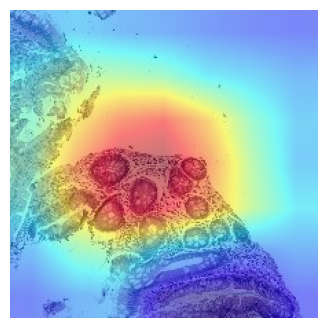

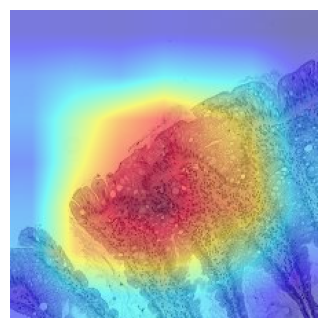

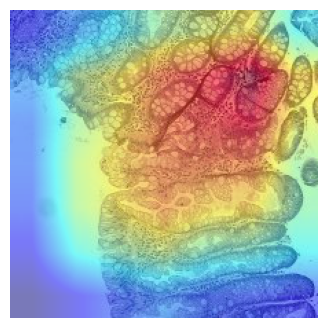

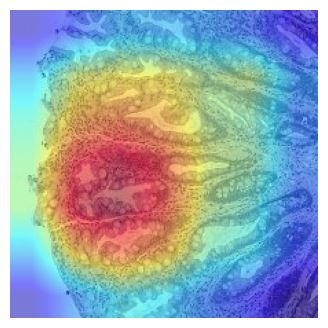

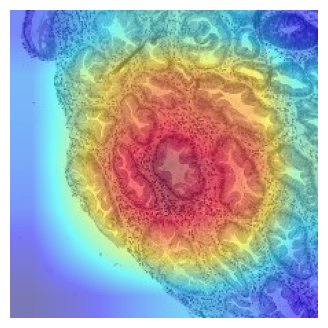

In [18]:
import torchvision
import numpy as np

paths = ['/content/drive/MyDrive/JJ/images/MHIST_aag.png', '/content/drive/MyDrive/JJ/images/MHIST_aah.png', '/content/drive/MyDrive/JJ/images/MHIST_aaq.png', '/content/drive/MyDrive/JJ/images/MHIST_aar.png', '/content/drive/MyDrive/JJ/images/MHIST_aay.png']


target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)
for path in paths:

  rgb_img = Image.open(path).convert('RGB')

  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

  input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
  grayscale_cam = cam(input_tensor=input_tensor)

  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # Image.fromarray(visualization, 'RGB')
  plt.figure(figsize=(4, 4))
  plt.imshow(Image.fromarray(visualization, 'RGB'))
  plt.axis('off')
  plt.show()

